# Predicting Heart Disease Diagnosis with Health Markers

### Introduction:

Heart disease is a major worldwide health concern because it is a common and potentially fatal disorder. To better understand, diagnose, and forecast heart illnesses, academics and healthcare practitioners are utilizing data-driven approaches thanks to technological advancements and the growing availability of health-related statistics. The UCI Heart Disease dataset stands as a valuable resource in this pursuit, offering a comprehensive set of attributes that can be analyzed to uncover patterns and insights related to cardiovascular health. The primary objective of this project is to address the question: "Can we predict heart disease diagnoses based on health markers?" By leveraging advanced approaches of classification and statistical analysis, the goal is to develop a model that can effectively distinguish between individuals with and without heart disease.

The data set includes many observations of individuals admitted to hospital with 14 variables, the five relevant to our preliminary analysis are:
1) chol: serum cholestoral	(mg/dl)
2) trest_bps: resting blood pressure (on admission to the hospital)	(mm Hg)
3) thalach: maximum heart rate achieved (bpm)
4) age: age of patient (years)
5) num: diagnosis of heart disease (0 is no presence. 1,2,3,4 is stage of heart disease)

### Preliminary exploratory data analysis:

First let's load the load all the nessecary packages and the data set with column names.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

heart_disease <- read_delim("processed.cleveland.data", 
                            col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
                                        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
head(heart_disease)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


The data is almost tidy, however NA values are specified as "?" in this data set so let's convert them to NA.

Now the data is tidy. Before we specify our training and testing data, let's standardize the variables that we will use for graphing. We can also create another variable that classifies the observation as either being diagnosed with heart disease or not without the range which will be easier to visualize.

In [2]:
heart_disease <- mutate(heart_disease, diagn=ifelse(is.na(num), NA, ifelse((num>0), "yes", "no")),
                                       diagn=as_factor(diagn),
                                       chol_standardized = scale(chol, center=TRUE),
                                       trestbps_standardized = scale(trestbps, center=TRUE), 
                                       age_standardized = scale(age, center=TRUE),
                                       thalch_standardized = scale(thalach, center=TRUE))
head(heart_disease)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagn,chol_standardized,trestbps_standardized,age_standardized,thalch_standardized
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,no,-0.26446281,0.75627397,0.9471596,0.01716893
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,yes,0.75915934,1.60855891,1.3897030,-1.81889638
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,yes,-0.34171732,-0.66420094,1.3897030,-0.90086373
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,no,0.06386882,-0.09601098,-1.9293722,1.63465503
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,no,-0.82455796,-0.09601098,-1.4868288,0.97891742
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,no,-0.20652194,-0.66420094,0.1727088,1.24121247


Now let's specify our training and testing data sets.

In [3]:
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

Now that we have our training data set, let's see the count of observations with heart disease and without to see if we will need to balance our data in the future.

In [4]:
heart_disease_count <- heart_disease_train |>
    group_by(diagn) |>
    summarize(count=n())

heart_disease_stage_count <- heart_disease_train |>
    group_by(num) |>
    summarize(count=n())

heart_disease_count
heart_disease_stage_count

diagn,count
<fct>,<int>
no,123
yes,102


num,count
<dbl>,<int>
0,123
1,40
2,27
3,26
4,9


As we can see the distribution is fairly reasonable with total observations with heart disease being slighlty greater than without.

Now let's create a few scatter plots of our testing data coloured by heart disease which could be useful when solving future classifications problem.

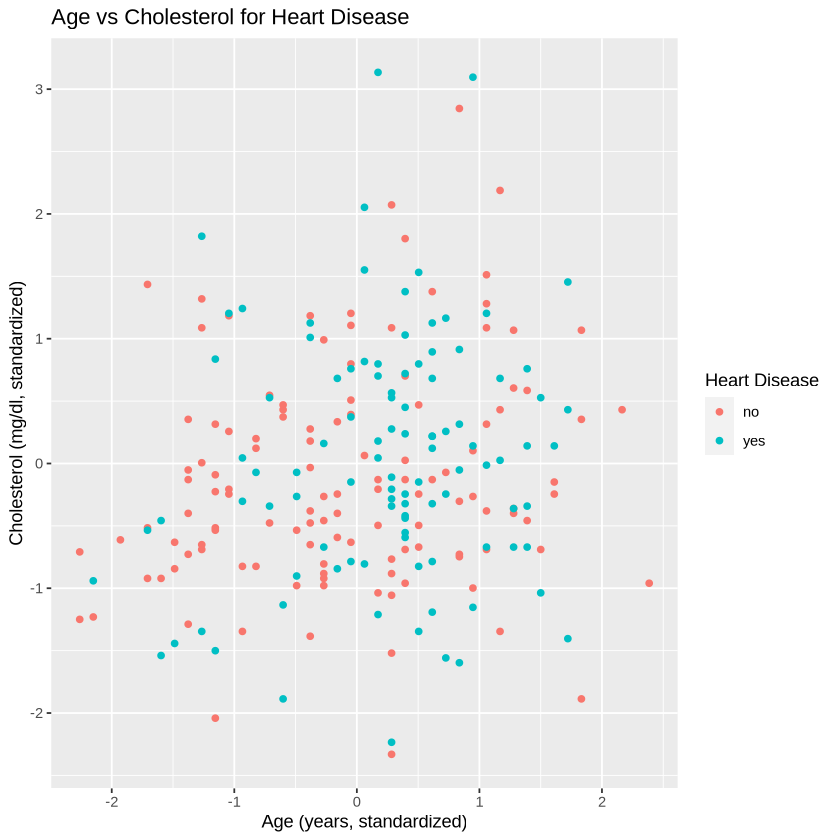

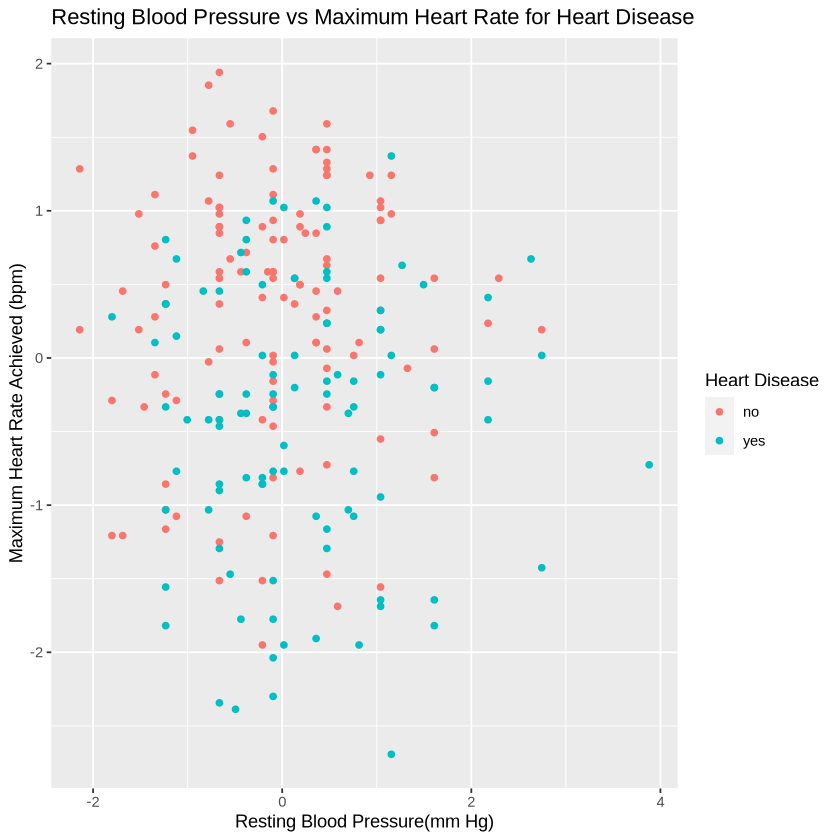

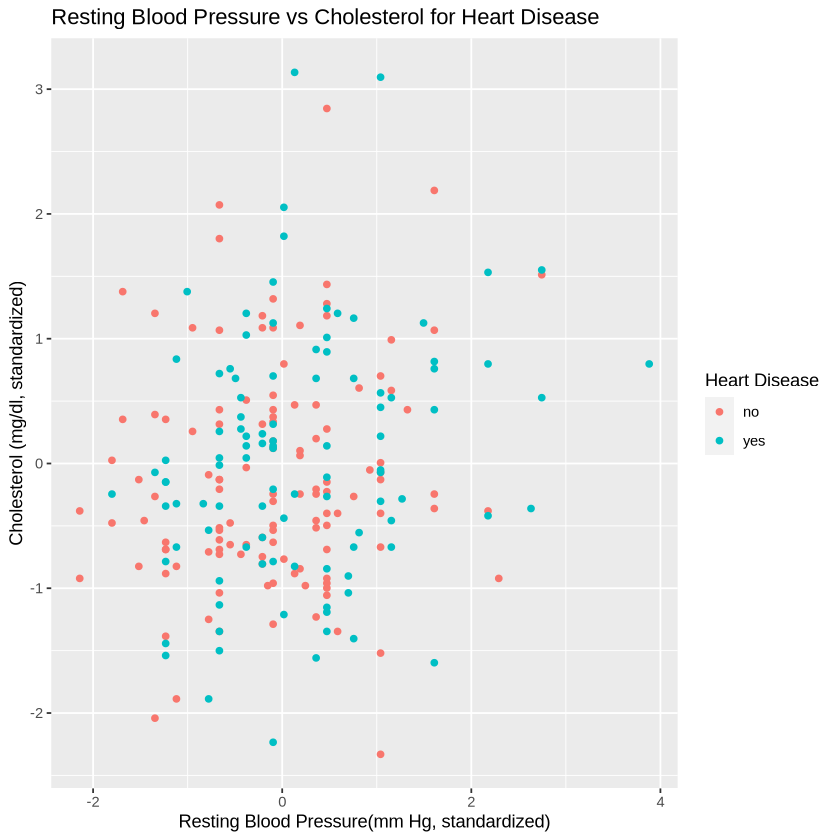

In [6]:
age_vs_chol <- ggplot(heart_disease_train, aes(x=age_standardized, y=chol_standardized, color=diagn)) +
    geom_point() +
    labs(x="Age (years, standardized)", y="Cholesterol (mg/dl, standardized)", color="Heart Disease", title="Age vs Cholesterol for Heart Disease")

trestbps_vs_thalch <- ggplot(heart_disease_train, aes(x=trestbps_standardized, y=thalch_standardized, color=diagn)) +
    geom_point() +
    labs(x="Resting Blood Pressure(mm Hg)", y="Maximum Heart Rate Achieved (bpm)", color="Heart Disease", title="Resting Blood Pressure vs Maximum Heart Rate for Heart Disease")

trestbps_vs_chol <- ggplot(heart_disease_train, aes(x=trestbps_standardized, y=chol_standardized, color=diagn)) +
    geom_point() +
    labs(x="Resting Blood Pressure(mm Hg, standardized)", y="Cholesterol (mg/dl, standardized)", color="Heart Disease", title="Resting Blood Pressure vs Cholesterol for Heart Disease")

age_vs_chol
trestbps_vs_thalch
trestbps_vs_chol

### Methods:

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed et dignissim elit. Fusce metus nunc, tristique vitae risus nec, aliquet vehicula arcu. Nam vehicula dui eros, ac vulputate dolor tincidunt at. Curabitur convallis consequat lorem a venenatis. Donec et urna nisl. Aenean pellentesque lorem et fringilla efficitur. Curabitur sed lacinia justo. Nulla facilisi. Morbi mauris turpis, finibus a vestibulum id, pharetra ut ex. Pellentesque ornare, lectus at ornare pharetra, mauris orci condimentum massa, nec mattis neque felis accumsan est. Aliquam eget nisl mauris. Vivamus pulvinar vulputate feugiat.

### Expected outcomes and significance:

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Quisque sed est luctus ante vehicula varius. Suspendisse eu neque faucibus, tristique quam eget, placerat enim. Etiam at nibh finibus, rutrum purus eu, hendrerit metus. Sed eget diam id tellus sollicitudin congue a sit amet arcu. Nam nec diam ipsum. Ut dapibus vestibulum lorem. Integer nec urna ut nibh cursus facilisis. Nullam in metus mattis metus bibendum fermentum id in nulla. Sed urna nisi, fringilla a suscipit sit amet, faucibus non justo. Aliquam convallis, risus quis efficitur molestie, libero lacus interdum est, at dictum ipsum dolor quis massa. Fusce ac ultrices eros. Etiam vel lacinia urna. Sed vel dui pharetra, gravida erat at, faucibus ligula.

### Sources

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.